In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np


In [3]:
#ทำนายการติดโรคมะเร้็งชนิดหนึ่ง 
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,...,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,...,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,...,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,...,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,...,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,...,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Data Preprocessing
**Check number of data**

In [4]:
df.shape

(1723, 23)

**Check any missing data in each column**

In [5]:
df.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
appearance    101
stage          24
pchemo          1
Wardsize      145
finalhisto     10
nodeyiel       12
RHlvsi        366
depth         489
size          114
utmet          98
vgmargin       96
vgmet          97
pelvicme        1
pmmet          94
adnmet          7
dtype: int64

**Delete column with missing data**

In [6]:
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)
df_clean_column.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
stage          24
pchemo          1
finalhisto     10
size          114
utmet          98
vgmet          97
pmmet          94
dtype: int64

**Delete row with at least 1 missing data ลบแถวที่มีข้อมูลที่ขาดหายไปอย่างน้อย 1 รายการ**

In [7]:
df_clean = df_clean_column.dropna(axis = 0)

**Total Clean Data**

In [8]:
df_clean.shape

(1555, 15)

**Check number of sample in pelvicme class**

In [9]:
pel_class = np.unique(df_clean['pmmet'])
pel_class

array([0., 1.])

In [10]:
pel_value = [sum(df_clean['pmmet']==pel_class[0]),
             sum(df_clean['pmmet']==pel_class[1])]
pel_value

[1278, 277]

**Separate pelviceme dataset into data (X) and label (y)**

In [11]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

**Separate Data into Train & Test (Note: Imbalance Dataset)แยกข้อมูลออกเป็น Train & Test (หมายเหตุ: ชุดข้อมูลไม่สมดุล**

In [12]:
from sklearn.model_selection import train_test_split #แบ่งข้อมูลออกเป็น2กลุ่ม จารย์ใช้สูตร80/20
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [13]:
#Data normalization to range of (0 to 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) #scaler = MinMaxScaler() งี้ก็ได้
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [14]:
np.min(X_train_norm, axis=0) 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
np.max(X_train_norm, axis=0) 

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

**Data normalization to range of (0 to 1)**

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

## Logistic Regression การถดถอยโลจิสติก

**10-Folds Cross Validation Training Accuracy with Tuning ความแม่นยำการฝึกอบรมการตรวจสอบข้าม 10 เท่าพร้อมการปรับแต่ง**

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 2, 4, 8, 16]}
clf = GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 1}
10CV accuracy : 83.36193548387098


**Test Accuracy**

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 84.56591639871382


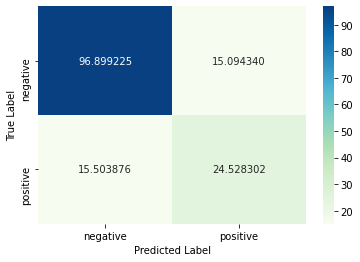

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

**The precision is the ratio tp / (tp + fp). The precision is the ability of the classifier not to label as positive a sample that is negative.**

**The recall is the ratio tp / (tp + fn). The recall is the ability of the classifier to find all the positive samples.**

**The F score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.**

**The support is the number of occurrences of each class in y_true.**
ความแม่นยำคืออัตราส่วน tp / (tp + fp) ความแม่นยำคือความสามารถของตัวแยกประเภทที่จะไม่ติดฉลากว่าตัวอย่างที่เป็นค่าบวกเป็นค่าลบ

การเรียกคืนคืออัตราส่วน tp / (tp + fn) การเรียกคืนคือความสามารถของตัวแยกประเภทในการค้นหาตัวอย่างที่เป็นบวกทั้งหมด

คะแนน F สามารถตีความได้ว่าเป็นค่าเฉลี่ยฮาร์มอนิกแบบถ่วงน้ำหนักของความแม่นยำและการเรียกคืน โดยที่คะแนน F-beta มีค่าสูงสุดที่ 1 และคะแนนแย่ที่สุดที่ 0

การสนับสนุนคือจำนวนครั้งของแต่ละคลาสใน y_true

In [20]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.86      0.97      0.91       258
    positive       0.62      0.25      0.35        53

    accuracy                           0.85       311
   macro avg       0.74      0.61      0.63       311
weighted avg       0.82      0.85      0.82       311



## Support Vector Machine

**10-Folds Cross Validation Training Accuracy ความแม่นยำการฝึกอบรมการตรวจสอบข้าม 10 เท่า**

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
params = {
    'C' : [1,2,4,8,16,32], # High C = Overfitting
    'gamma' : [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32] # High gamma = Overfitting
}
clf = GridSearchCV(SVC(),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 8, 'gamma': 0.5}
10CV accuracy : 84.2458064516129


**Test Accuracy**

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
100*sum(y_test == y_predict)/len(y_test)

81.67202572347267

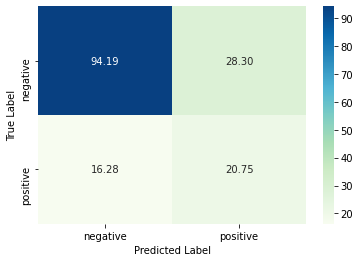

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [24]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.94      0.90       258
    positive       0.42      0.21      0.28        53

    accuracy                           0.82       311
   macro avg       0.64      0.57      0.59       311
weighted avg       0.78      0.82      0.79       311



## Random Forest

**10-Folds Cross Validation Training Accuracy**

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100,200,500],
    'min_samples_leaf' : [1,2,4,8,16,32],
    'max_features' : ['sqrt',0.5,0.8],
    'criterion' : ['gini','entropy']
}
clf = GridSearchCV(RandomForestClassifier(random_state=0),params, cv = 10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'criterion': 'entropy', 'max_features': 0.8, 'min_samples_leaf': 4, 'n_estimators': 100}
10CV accuracy : 84.64903225806452


In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.8135048231511254

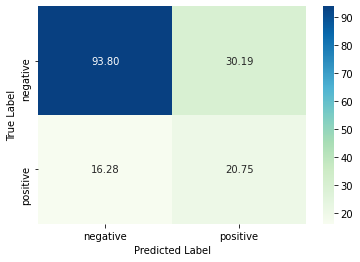

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [28]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.94      0.89       258
    positive       0.41      0.21      0.28        53

    accuracy                           0.81       311
   macro avg       0.63      0.57      0.58       311
weighted avg       0.78      0.81      0.79       311



## XGBoost

**10-Folds Cross Validation Training Accuracy**

In [29]:
!pip install xgboost

**Test Accuracy**

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.8135048231511254

In [31]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [20,30,300,200,500],
    'min_samples_leaf' : [1,2,4,8,16,32],
    'max_features' : ['sqrt',0.5,0.8],
    'criterion' : ['gini','entropy']
}
clf = GridSearchCV(RandomForestClassifier(random_state=0),params, cv = 10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'criterion': 'entropy', 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 30}
10CV accuracy : 84.73032258064516


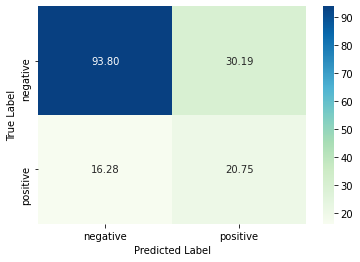

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [33]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.94      0.89       258
    positive       0.41      0.21      0.28        53

    accuracy                           0.81       311
   macro avg       0.63      0.57      0.58       311
weighted avg       0.78      0.81      0.79       311



# Homework

Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {'C': [0.89,0.85,0.83],
        'fit_intercept':[True],
         'penalty':['l2'],
         'fit_intercept':[True],
         'class_weight':[None],
         'multi_class':['auto'],
          'tol':[0.001],
          'dual':[False]
         }
clf = GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 0.89, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'tol': 0.001}
10CV accuracy : 83.5225806451613


In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 84.88745980707395


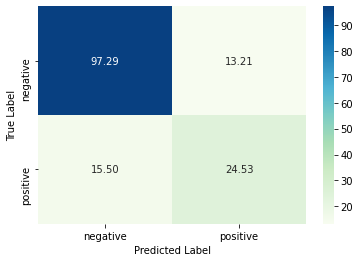

In [36]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [37]:

print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.86      0.97      0.91       258
    positive       0.65      0.25      0.36        53

    accuracy                           0.85       311
   macro avg       0.76      0.61      0.64       311
weighted avg       0.83      0.85      0.82       311

